
# A point analysis of weak learning models

    Notebook version: 1.1 (Feb 2, 2017)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)
               

    Changes: v.1.0 - First version

In [1]:
# To visualize plots in the notebook
%matplotlib inline 

# Import some libraries that will be necessary for working with data and displaying plots
# import csv     # To read csv files
# import random
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
# from sklearn import neighbors, datasets
import wlc.WLweakener2 as wlw


## 1. Introduction.

In this notebook we analyze the behavior of sample based estimates of a $C$-dimensional probability vector $\boldsymbol{\eta}$ from binary vector instances.

The main goal is to compare the behavior of a "supervised" estimate, based on a set of labels $\{{\bf y}_k, k=0,\ldots, K-1\}$ generated from $\boldsymbol{\eta}$, and estimates based on weak labels, $\{{\bf b}_k, k=0,\ldots, K-1\}$, generated from some related distribution ${\bf q} = {\bf M}\boldsymbol{\eta}$, where ${\bf M}$ is called a mixing matrix and contains conditional probabilities.

To do so, we will generate a dataset of labels drawn from $\boldsymbol{\eta}$, and one or more datasets of weak labels drawn from ${\bf q}$.

First we define some configurable parameters:

Mixing matrix:
[[ 0.          0.          0.33333333]
 [ 0.          0.33333333  0.        ]
 [ 0.          0.33333333  0.33333333]
 [ 0.33333333  0.          0.        ]
 [ 0.33333333  0.          0.33333333]
 [ 0.33333333  0.33333333  0.        ]]


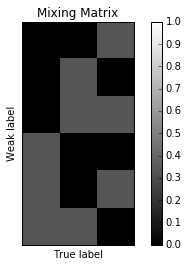

In [2]:
C = 3                             # Number of classes
K = 10000                          # Sample size
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

# Mixing matrix
M = wlw.computeM(C, beta=0.5, method='quasi_IPL')
# M = wlw.computeM(C, beta=0.4, method='noisy')
M = M[np.sum(M, axis=1) > 0]   # This is to remove zero rows, which are not relevant

# Show:
print "Mixing matrix:"
print M
plt.imshow(M, interpolation='nearest', cmap="gray", clim=(0.0, 1.0)) 
plt.colorbar()
plt.title('Mixing Matrix')
plt.xlabel('True label')
plt.ylabel('Weak label')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### 1.1. Dataset generation.

In the following we will generate a dataset of labels and their corresponding weak labels

In [3]:
# Generate true labels
I = np.eye(C)
iy = np.random.choice(np.arange(0, C), size=K, p=eta)
y = I[iy]

# Generate weak label indices
iz = wlw.generateWeak(iy, M, C)

### 1.2. Supervised, sample based estimation.

In the supervised setting, ${\bf y}$ is observed an the optimal sample based estimate of $\boldsymbol{\eta}$ (minimizing any Bregmann divergence) based on the observed labels is the sample average

In [4]:
f = np.mean(y, axis=0)
print "Supervised estimate: {0}".format(f)
e2 = np.sum((f - eta)**2)
print "Square error: {0}".format(e2)

Supervised estimate: [ 0.5083  0.198   0.2937]
Square error: 0.00011258


### 1.3. Learning from weak labels.

There are many ways to estimate $\boldsymbol{\eta}$ from the weak labels. We consider here a representative sample of them:

#### 1.3.1. Averaging virtual labels

If ${\bf z}$ is a sample from distribution ${\bf q}$, and ${\bf V}$ is any left inverse of the mixing matrix (so that ${\bf V}{\bf M} = {\bf I}$ then it can be shown that $\mathbb{E}\{{\bf v}\} = \boldsymbol{\eta}$. Therefore, we can estimate $\boldsymbol{\eta}$ as the average of virtual labels:

In [5]:
# v = wlw.computeVirtual(iz, C, method='quasi_IPL')
v = wlw.computeVirtual(iz, C, M=M, method='Mproper')
print "Virtual labels are:"
print v
f_v = np.mean(v, axis=0)

print "Virtual label estimate: {0}".format(f_v)
e2 = np.sum((f_v - eta)**2)
print "Square error: {0}".format(e2)

Virtual labels are:
[[ 0.9 -0.6  0.9]
 [-0.3  1.2 -0.3]
 [-0.6  0.9  0.9]
 ..., 
 [ 1.2 -0.3 -0.3]
 [ 0.9  0.9 -0.6]
 [ 0.9  0.9 -0.6]]
Virtual label estimate: [ 0.52161  0.19116  0.28911]
Square error: 0.000663729799996


#### 1.3.2. Maximum Likelihood Estimate

The expected value of a virtual label vector can be shown to be equal to the minimizer of the expected log likelihood. This implies that, on average, the average of the virtual label vector and the ML estimate shuld be assymptotically equivalent. However, for a finite sample size, they can lead to different results.

The following function computes the ML estimate by means of the EM algorithm.

In [7]:
def computeML(iz, M, f0=None, max_iter=1e10, echo='off'):
    """
    Compute the ML estimate of a probability vector based on weak labels in iz and the mixing matrix M.
    The estimation method is based on Expectation Maximization.
    """

    # Initialize the estimate.
    if f0 is None:
        C = M.shape[1]   # No. of classes
        f_ml = np.ones(C)/C
    else:
        f_ml = f0

    # Recursive estimation
    iterate = True
    count = 0
    while iterate:
        fi = np.dot(np.diag(f_ml), M.T)[:,iz.astype(int)]
        fi = fi / np.sum(fi, axis=0)
        f_new = np.mean(fi, axis=1)
        count += 1
        iterate = np.any(f_new != f_ml) and count < max_iter
        f_ml = np.copy(f_new)
    
    if echo=='on':
        if count>= max_iter:
            print "Stopped before convergence after {0} iterations".format(max_iter)
        else:
            print "Converged in {0} iterations".format(count)

    return f_ml

def computeNLL(iz, M, f):
    """
    Compute the Log-Likelihood function for an estimate f.
    """
    
    I = np.eye(M.shape[0])
    z = I[iz.astype(int)]
    NLL = - np.dot(np.mean(z, axis=0), np.log(np.dot(M, f)))

    return NLL


We can verify that the EM steps monotonically decrease the NLL

Converged in 56 iterations
eta = [ 0.5  0.2  0.3]
f_ml = [ 0.52020299  0.19300616  0.28679085]
f_v = [ 0.52161  0.19116  0.28911]


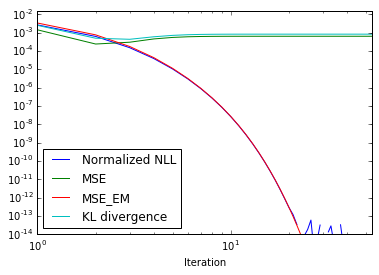

The final estimate is [ 0.52020299  0.19300616  0.28679085]
The true label is [ 0.5  0.2  0.3]


In [9]:
n_it = 10000

f = None
NLL = []
MSE = []
KL = []
MSE_EM = []

I = np.eye(M.shape[0])
z = I[iz.astype(int)]
q = np.mean(z, axis=0)

f_lim = computeML(iz, M, f, max_iter=10000, echo='on')

for i in range(n_it):
    
    f_new = computeML(iz, M, f, max_iter=1)
    
    if f is not None and np.all(f_new == f):
        break
    else:
        f = np.copy(f_new)

    # NLL.append(computeNLL(iz, M, f) + np.dot(q, np.log(q)))
    NLL.append(computeNLL(iz, M, f) + np.dot(q, np.log(np.dot(M, f_lim))))
    MSE.append(np.sum((f - eta)**2))
    KL.append(- np.dot(eta, np.log(f)) + np.dot(eta, np.log(eta)))
    MSE_EM.append(np.sum((f - f_lim)**2))

print "eta = {0}".format(eta)
print "f_ml = {0}".format(f)
print "f_v = {0}".format(f_v)
its = range(len(NLL))
plt.loglog(its, NLL, label= "Normalized NLL")
plt.loglog(its, MSE, label= "MSE")
plt.loglog(its, MSE_EM, label= "MSE_EM")
plt.loglog(its, KL, label= "KL divergence")
plt.legend(loc='best')
plt.axis('tight')
plt.xlabel('Iteration')
plt.ylim((1e-14, plt.ylim()[1]))
plt.show()
print "The final estimate is {0}".format(f)
print "The true label is {0}".format(eta)


In [10]:
f_ml = computeML(iz, M, max_iter=100000, echo='on')

print "ML estimate: {0}".format(f_ml)
e2 = np.sum((f_ml - eta)**2)
print "Square error: {0}".format(e2)

Converged in 56 iterations
ML estimate: [ 0.52020299  0.19300616  0.28679085]
Square error: 0.000631556375946


## 2. Statistical analysis of the MSE.

We will compute all estimates multiple times in order to compare the distribution of the MSE.

First, to make sure that the WLL estimate is working properly, we plot the convergence of the estimate with the number of iterations

In [11]:
n_sim = 100
mse = {'wll': []}
K = 1000
for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print '\r Simulation {0} out of {1}'.format(str(n+1), n_sim),
    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)
    # Estimation with virtual labels
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.cumsum(v, axis=0) / np.arange(1, K+1)[:,np.newaxis]
    mse_n = np.sum((f_v - eta)**2, axis=1)
    mse['wll'].append(mse_n)    


 Simulation 100 out of 100


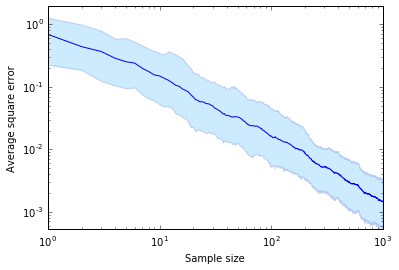

In [12]:
mse_mean = np.mean(mse['wll'], axis=0)
d = mse['wll'] - mse_mean
mse_std_u = np.sqrt(np.sum(d**2*(d >=0), axis=0)/np.sum((d >=0), axis=0))
mse_std_d = np.sqrt(np.sum(d**2*(d <=0), axis=0)/np.sum((d <=0), axis=0))
plt.fill_between(range(K), mse_mean - mse_std_d, mse_mean + mse_std_u,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, linestyle='solid', antialiased=True)
plt.loglog(range(K), mse_mean)
plt.axis('tight')
plt.xlabel('Sample size')
plt.ylabel('Average square error')
plt.show()

### 2.1. Supervision vs partial supervision

In the following we test, for a fixed sample size, the estimation of $\boldsymbol{\eta}$ as the average of virtual labels, in comparison with a complete supervision, as the average of the true labels.

In [13]:
n_sim = 100
mse = {'sup': [], 'wll': [], 'wml': []}
I_C = np.eye(C)

for n in range(n_sim):
 
    if (n+1)/1*1 == n+1:
        print '\r Simulation {0} out of {1}'.format(str(n+1), n_sim),

    # Generate true labels
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I_C[iy]

    # Generate weak label indices
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)
    mse['sup'].append(np.sum((f - eta)**2))

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    mse['wll'].append(np.sum((f_v - eta)**2))

    # Estimation with ML-EM
    f_ml = computeML(iz, M, f0=None, max_iter=1000, echo='off')
    mse['wml'].append(np.sum((f_ml - eta)**2))

 Simulation 100 out of 100


The following error plots shows, that, under very weak supervision, there is a significant performance degradation caused by the use of weak labels.

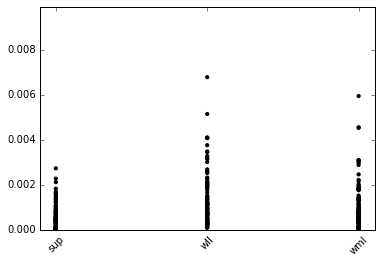

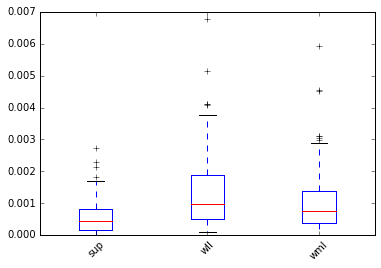

In [14]:
tag_list = ['sup', 'wll', 'wml']
for i, tag in enumerate(tag_list):
    plt.scatter([i + 1]*n_sim, mse[tag], c=[i]*n_sim, s=10, cmap='copper')

plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.axis('tight')
plt.ylim((0, plt.ylim()[1]))
plt.show(block=False)

plt.boxplot([mse[tag] for tag in tag_list])
plt.xticks(range(1, 1 + len(tag_list)), tag_list, rotation='45')
plt.show()

## 3. Combination of datasets

In the following experiments we explore the combination of a fully labeled dataset with a weakly labeled dataset. We show that the beharior of the estimate based on virtual label depends on the choice of the virtual label vector.

The experiment demonstrates that, though different virtual label matrices can be asymptotically equivalent for the estimation of the probability vector, they show a different behavior under finite samples. 

### 3.1. Weighting samples

In the following experiments we explore virtual matrices ${\bf V}$ which are a combination of virtual matrices from the original datasets, i.e. they have the form ${\bf V} = (w{\bf V}_0, (1-w){\bf V}_1)$ where ${\bf V}_0$ and ${\bf V}_1$ are virtual matrices for the original datasets. We show that the empirical mse depends on $w$, and there is an optimal choice for $w$.

Note that the experiment does not explore all posible virtual matrices (i.e. all left inverses of the mixing matrix), but only those that are a composition of two virtual matrices.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100

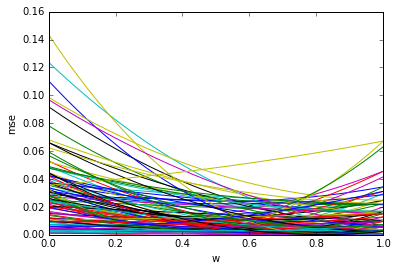

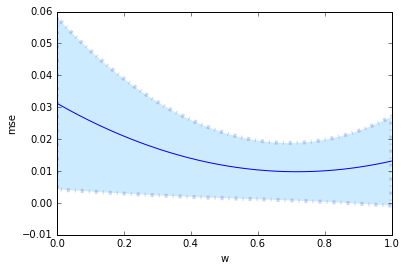

In [15]:
n_sim = 100
K = 50

mse = []
for n in range(n_sim):

    if (n+1)/1*1 == n+1:
        print str(n+1),

    # Generate fully labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    y = I_C[iy]

    # Generate weakly labeled dataset
    iy = np.random.choice(np.arange(0, C), size=K, p=eta)
    iz = wlw.generateWeak(iy, M, C)

    # Supervised estimation
    f = np.mean(y, axis=0)

    # Estimation with virtual labels
    # v = wlw.computeVirtual(iz, C, method='quasi_IPL')
    v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
    f_v = np.mean(v, axis=0)
    
    # Combination of virtual labels. 
    # Al values of w provide consistent virtual matrices. However, the msw for a finite sample depends on w.
    w = np.arange(0, 1, 0.001)[:, np.newaxis]
    f_est = f * w + f_v * (1 - w)
    mse_n = np.sum((f_est - eta)**2, axis=1)
    mse.append(mse_n)

plt.plot(w.flatten(), np.array(mse).T)
plt.xlabel('w')
plt.ylabel('mse')
plt.show()

mse_mean =  np.mean(np.array(mse), axis=0)
mse_std = np.std(np.array(mse), axis=0)
plt.plot(w.flatten(), mse_mean)
plt.fill_between(w.flatten(), mse_mean - mse_std, mse_mean + mse_std,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, linestyle='dashdot', antialiased=True)
plt.xlabel('w')
plt.ylabel('mse')
plt.show()


### 3.2. Optimal weight versus noise level

The following experiment shows that the relation between the noise level and the optimal weight might be non-trivial.

In [16]:
C = 3            # Number of classes
Ktrue = 4000       # Number of clean labels
Kweak = 4000       # Number of weak labels       
qTrue = float(Ktrue)/(Ktrue + Kweak)
qWeak = float(Kweak)/(Ktrue + Kweak)
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

beta_set = np.linspace(0, 1, 11)
n_sim = 100      # Number of experiments for each value of eta.
wmse = []
wkld = []
w = np.linspace(0, 1, 101)[:, np.newaxis]/ qTrue

for beta in beta_set:

    print "\rBeta = {0}".format(beta),
    
    # Mixing matrix
    M = wlw.computeM(C, beta=beta, method='noisy')

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)
        
    np.random.seed(0)
    mse = []
    kld = []
    for n in range(n_sim):

        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I_C[iy]

        # Generate weakly labeled dataset
        iy2 = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        iz2 = wlw.generateWeak(iy2, M, C)

        # Supervised estimation
        f = np.mean(y, axis=0)

        # Estimation with virtual labels
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz2.astype(int)]
        f_v = np.mean(v, axis=0)
        
        if np.any(f_v<=0):
            print f_v

        # Weighted average
        f_est = f * w * qTrue + f_v * (1 - w * qTrue)
        # f_est = f * w + f_v * (1 - w)
        mse_n = np.sum((f_est - eta)**2, axis=1)
        mse.append(mse_n)
        
        kld_n = - np.dot(eta, np.log(f_est.T)) 
        kld.append(kld_n)

    mse_mean =  np.mean(np.array(mse), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin])
    
    kld_mean =  np.mean(np.array(kld), axis=0)
    imin = np.argmin(kld_mean)
    wkld.append(w[imin])

Beta = 0.7 [ 0.77  -0.035  0.265]
[ 0.715  0.3   -0.015]


/Users/jcid/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in log


[ 0.435 -0.14   0.705]
[ 0.67 -0.08  0.41]
[ 0.73 -0.14  0.41]
[ 0.475 -0.02   0.545]
[ 0.6   -0.055  0.455]
[ 0.73  0.31 -0.04]
[ 0.59 -0.01  0.42]
[ 0.525 -0.005  0.48 ]
[ 0.69 -0.01  0.32]
[ 0.515 -0.04   0.525]
Beta = 1.0


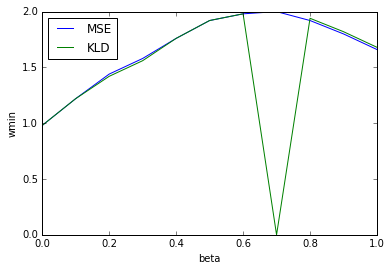

In [17]:
plt.plot(beta_set, np.array(wmse).flatten(), label="MSE")
plt.plot(beta_set, np.array(wkld).flatten(), label="KLD")
plt.xlabel('beta')
plt.ylabel('wmin')
plt.legend(loc='best')
plt.show()

The last experiment shows several important issues:

* The optimal weights could be independent on the choice of the proper loss
* The average of the virtual labels can be out of the probability simplex. In this respect, the optimal probability estimate should be computed with the constraint that the estimate lies inside the probability simplex. (Negative values are the cause of the anomalies in the KL divergence weighs).


### 3.3. A comparison between EM, virtual labels and the optimal weights

The following section shows that, despite ML-EM and weak losses may lead to different results, they can show very similar performance, though the results may depend on the selection of the configurable parameters (in particular, label proportions and mixing matrix).

In [21]:
C = 3            # Number of classes
Ktrue = 20       # Number of clean labels
Kweak = 40       # Number of weak labels       
qTrue = float(Ktrue)/(Ktrue + Kweak)
qWeak = float(Kweak)/(Ktrue + Kweak)
eta = np.array([0.5, 0.2, 0.3])   # True probability vector

beta_set = np.linspace(0, 1, 21)
n_sim = 1000      # Number of experiments for each value of eta.
wmse = []
w = np.linspace(0, 1, 101)[:, np.newaxis]/ qTrue

mse_w = []
mse_v = []
mse_ml = []
wtest = []
wpseudo = []

for beta in beta_set:

    print "\rBeta = {0}".format(beta),
    
    # Mixing matrix
    # M = wlw.computeM(C, beta=beta, method='quasi_IPL')
    M = wlw.computeM(C, beta=beta, method='noisy')

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)

    # Compute combined mixing matrix
    M2 = np.vstack((qTrue*np.eye(C), qWeak*M))
    V2 = np.linalg.pinv(M2)

    np.random.seed(0)
    mse_wn = []
    mse_vn = []
    mse_mln = []

    for n in range(n_sim):

        # #####################
        # ## Dataset generation
        
        # Generate fully labeled dataset
        iy = np.random.choice(np.arange(0, C), size=Ktrue, p=eta)
        y = I_C[iy]

        # Generate weakly labeled dataset
        iy2 = np.random.choice(np.arange(0, C), size=Kweak, p=eta)
        iz = wlw.generateWeak(iy2, M, C)
        # Join datasets
        iz2 = np.hstack((iy, iz + C))

        # #######################
        # ## Weighted combination
        
        # Supervised estimation with dataset 0
        f = np.mean(y, axis=0)

        # Estimation with virtual labels and dataset 1
        # v = wlw.computeVirtual(iz, C, method='Mproper', M=M)
        v = V.T[iz.astype(int)]
        
        f_v = np.mean(v, axis=0)
        
        # Weighted average
        f_est = f*w*qTrue + f_v*(1-w*qTrue)
        mse_wn.append(np.sum((f_est - eta)**2, axis=1))

        # #######################
        # ## (pinv) M-proper loss
        v2 = V2.T[iz2.astype(int)]
        f_v2 = np.mean(v2, axis=0)
        mse_vn.append(np.sum((f_v2 - eta)**2))        
        
        # ##############
        # ## ML estimate
        f_ml = computeML(iz2, M2, f0=None, max_iter=1000, echo='off')
        mse_mln.append(np.sum((f_ml - eta)**2))
        
    mse_mean =  np.mean(np.array(mse_wn), axis=0)
    imin = np.argmin(mse_mean)
    wmse.append(w[imin])
    mse_w.append(np.min(mse_mean))

    mse_v.append(np.mean(np.array(mse_vn), axis=0))
    mse_ml.append(np.mean(np.array(mse_mln), axis=0))
    
    F11 = qWeak**2 * np.linalg.norm(np.dot(M, V), 'fro')**2
    F10 = qWeak**2 * np.linalg.norm(M, 'fro')**2
    F01 = qTrue**2 * np.linalg.norm(V, 'fro')**2
    F00 = qTrue**2*C
    w0= qTrue*C/(F00 + F10)
    
    wtest.append(qTrue*(F11 + F01) / (qTrue**2*(F11+F01) + qWeak**2*(F00+F10)))
    wpseudo.append((w0/qTrue-1))

Beta = 1.0


In [22]:
beta_set = np.linspace(0, 1, 21)
wtest = []
wpseudo = []

for beta in beta_set:

    # Mixing matrix
    # M = wlw.computeM(C, beta=beta, method='quasi_IPL')
    M = wlw.computeM(C, beta=beta, method='noisy')

    # Compute virtual matrix (this is to compute virtual labels in a more efficient way
    # than the current implementation of ComputeVirtual in WLweakener)
    V = np.linalg.pinv(M)

    # Compute combined mixing matrix
    M2 = np.vstack((qTrue*np.eye(C), qWeak*M))
    V2 = np.linalg.pinv(M2)

    F11 = qWeak**2 * np.linalg.norm(np.dot(M, V), 'fro')**2
    F10 = qWeak**2 * np.linalg.norm(M, 'fro')**2
    F01 = qTrue**2 * np.linalg.norm(V, 'fro')**2
    F00 = qTrue**2*C
    w0= qTrue*C/(F00 + F10)
    
    wtest.append(qTrue*(F11 + F01) / (qTrue**2*(F11+F01) + qWeak**2*(F00+F10)))
    wpseudo.append(w0/qTrue-1)

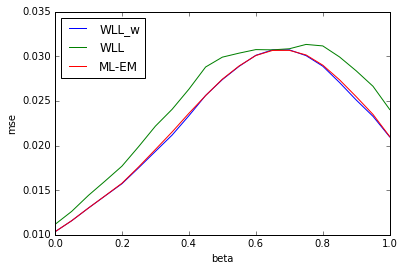

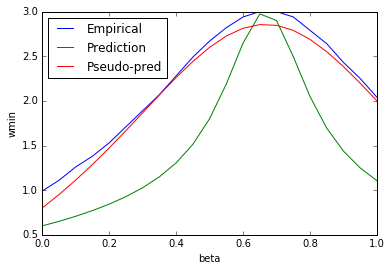

[ 0.99  1.11  1.26  1.38  1.53  1.71  1.89  2.07  2.28  2.49  2.67  2.82
  2.94  3.    3.    2.94  2.79  2.64  2.43  2.25  2.04]


In [23]:
plt.plot(beta_set, np.array(mse_w).flatten(), label="WLL_w")
plt.plot(beta_set, np.array(mse_v).flatten(), label="WLL")
plt.plot(beta_set, np.array(mse_ml).flatten(), label="ML-EM")
plt.xlabel('beta')
plt.ylabel('mse')
# plt.ylim((0, np.max(mse_w)+0.001))
plt.legend(loc='best')
plt.show()

plt.plot(beta_set, np.array(wmse).flatten(), label="Empirical")
plt.plot(beta_set, np.array(wtest).flatten(), label="Prediction")
plt.plot(beta_set, np.array(wpseudo).flatten(), label="Pseudo-pred")
plt.xlabel('beta')
plt.ylabel('wmin')
plt.legend(loc="best")
plt.show()
print np.array(wmse).flatten()

In [24]:
beta_set = np.linspace(0, 1, 21)
print beta_set

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.  ]
